In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [2]:
df=pd.read_csv("penguins_size.csv")
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


# Data Preprocessing

## EDA

In [4]:
df['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [5]:
df['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [6]:
df['island'].value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

In [7]:
df['sex'].value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

In [8]:
df=df[df['sex']!='.']
df.shape

(343, 7)

<AxesSubplot:xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

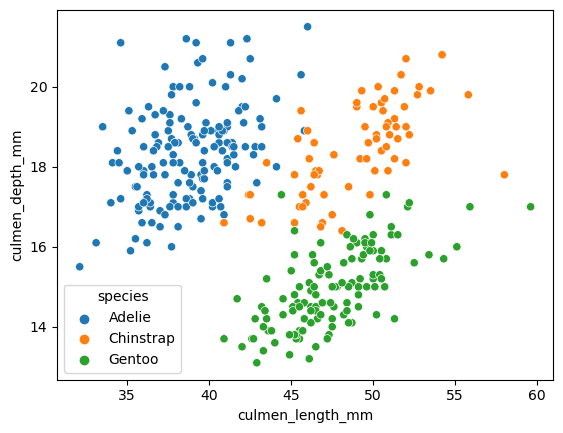

In [9]:
sns.scatterplot(x='culmen_length_mm',y='culmen_depth_mm',hue='species',data=df)

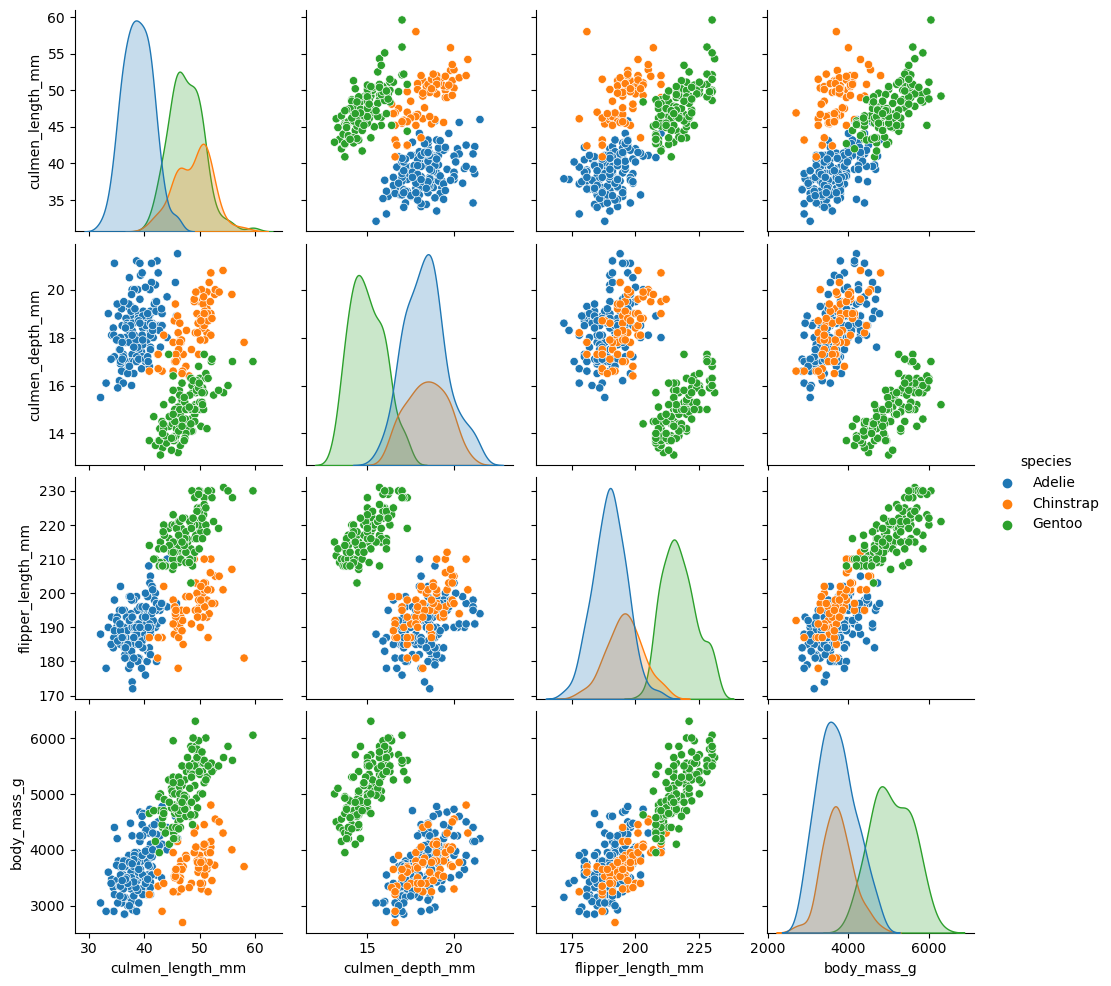

In [10]:
sns.pairplot(df,hue='species')
plt.show()

## Data cleaning

In [11]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [12]:
df=df.dropna()
df.shape

(333, 7)

## Encoding

In [31]:
df1=df.drop("species",axis=1)
X=pd.get_dummies(df1,drop_first=True)
y=df["species"]

## Train_Test_Split

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

## Modelling and Evaluation

In [33]:
#Decision tree classifier - with default parameters
from sklearn.tree import DecisionTreeClassifier
dt_default=DecisionTreeClassifier(random_state=0)
dt_default.fit(X_train,y_train)

#Prediction
pred_train=dt_default.predict(X_train)
base_pred=dt_default.predict(X_test)

#Evaluation
#1.Train & test accuracy
from sklearn.metrics import accuracy_score
print("Train accuracy",accuracy_score(pred_train,y_train))
print("Test accuracy",accuracy_score(base_pred,y_test))

#2.Cross Validation Score
from sklearn.model_selection import cross_val_score
scores=cross_val_score(dt_default,X,y,cv=5)
print("cross validation score:",scores.mean())

Train accuracy 1.0
Test accuracy 0.98
cross validation score: 0.9698778833107191


In [34]:
dt_default.predict([[30,20,150,4000,1,0,1]])

array(['Adelie'], dtype=object)

## visualize the tree

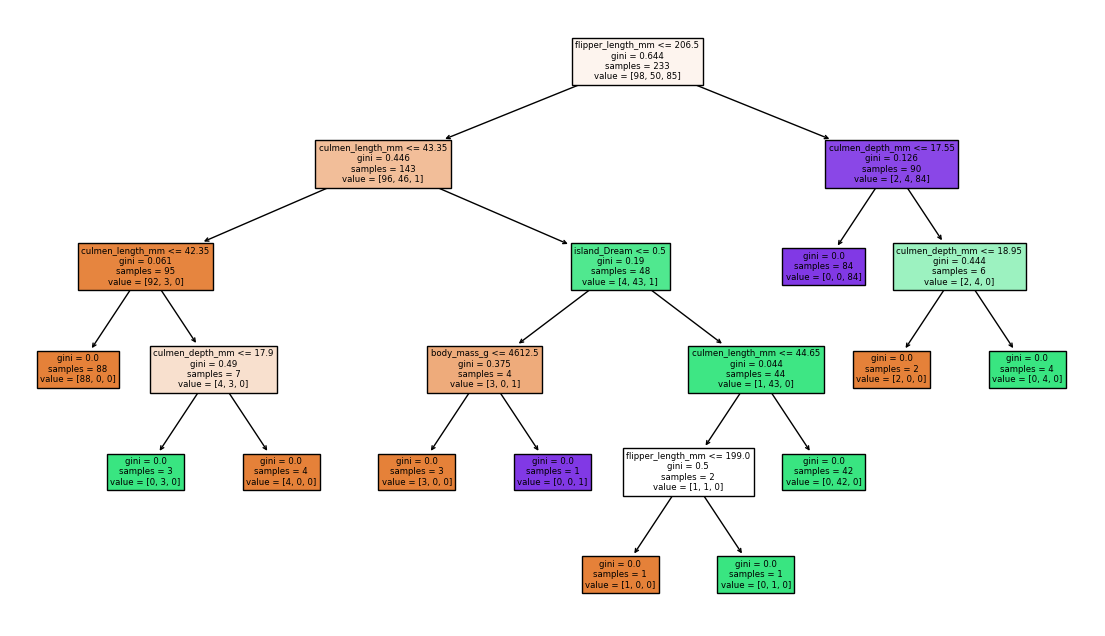

In [35]:
from sklearn.tree import plot_tree
plt.figure(figsize=(14,8),dpi=100)
plot_tree(dt_default,filled=True,feature_names=X.columns)
plt.show()

### Importance of each feature given by this model

In [36]:
dt_default.feature_importances_

array([0.34756206, 0.09868076, 0.50596782, 0.00999714, 0.03779222,
       0.        , 0.        ])

In [37]:
pd.DataFrame(index=X.columns,data=dt_default.feature_importances_,columns=['Feature Importance'])

,Feature Importance
culmen_length_mm,0.347562
culmen_depth_mm,0.098681
flipper_length_mm,0.505968
body_mass_g,0.009997
island_Dream,0.037792
island_Torgersen,0.000000
sex_MALE,0.000000


### Hyper Parameter tuning

In [38]:
from sklearn.model_selection import GridSearchCV

estimator=DecisionTreeClassifier(random_state=0)

param_grid={'criterion':["gini","entropy"],'max_depth':[1,2,3,4]}

grid=GridSearchCV(estimator,param_grid,scoring='accuracy',cv=5)
grid.fit(X_train,y_train)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 3}

## Final decision tree model

### with best hyperparameters and with imp features 

In [39]:
X=X.drop(["island_Torgersen","sex_MALE"],axis=1)

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=0)

dt_bhp=DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
dt_bhp.fit(X_train,y_train)

ypred_train=dt_bhp.predict(X_train)
ypred_test=dt_bhp.predict(X_test)

print("Train_accuracy:",accuracy_score(ypred_train,y_train))
print("Test_accuracy:",accuracy_score(ypred_test,y_test))

scores=cross_val_score(dt_bhp,X,y,cv=5)
print("Cross validation score:", scores.mean())

Train_accuracy: 0.9871244635193133
Test_accuracy: 0.95
Cross validation score: 0.9638625056535505


### predict on single value

In [40]:
dt_bhp.predict([[30,20,150,4000,1]])

array(['Adelie'], dtype=object)

### Optimization--Pruning of decision tree

In [41]:
def report_model(model):
    model.fit(X_train,y_train)
    model_preds=model.predict(X_test)
    pred_train=model.predict(X_train)
    print("Train accuracy:",accuracy_score(y_train,pred_train))
    print("Test accuracy:",accuracy_score(y_test,model_preds))
    plt.figure(figsize=(12,8),dpi=150)
    plot_tree(model,filled=True,feature_names=X.columns)

### max depth

Train accuracy: 0.9871244635193133
Test accuracy: 0.95


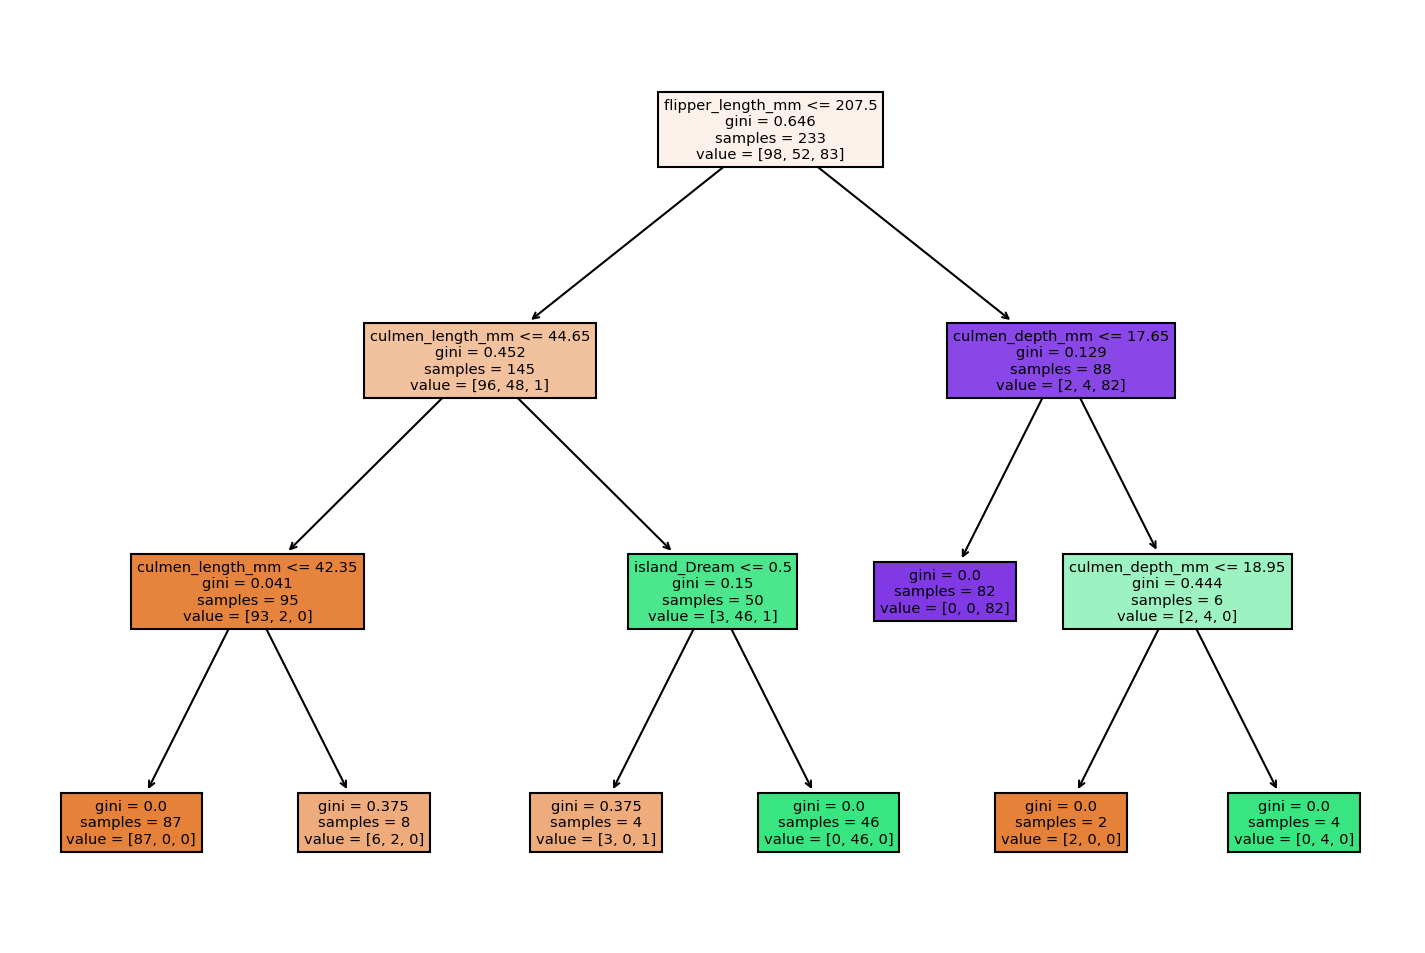

In [42]:
pruned_tree=DecisionTreeClassifier(max_depth=3)
report_model(pruned_tree)

Train accuracy: 0.9871244635193133
Test accuracy: 0.95


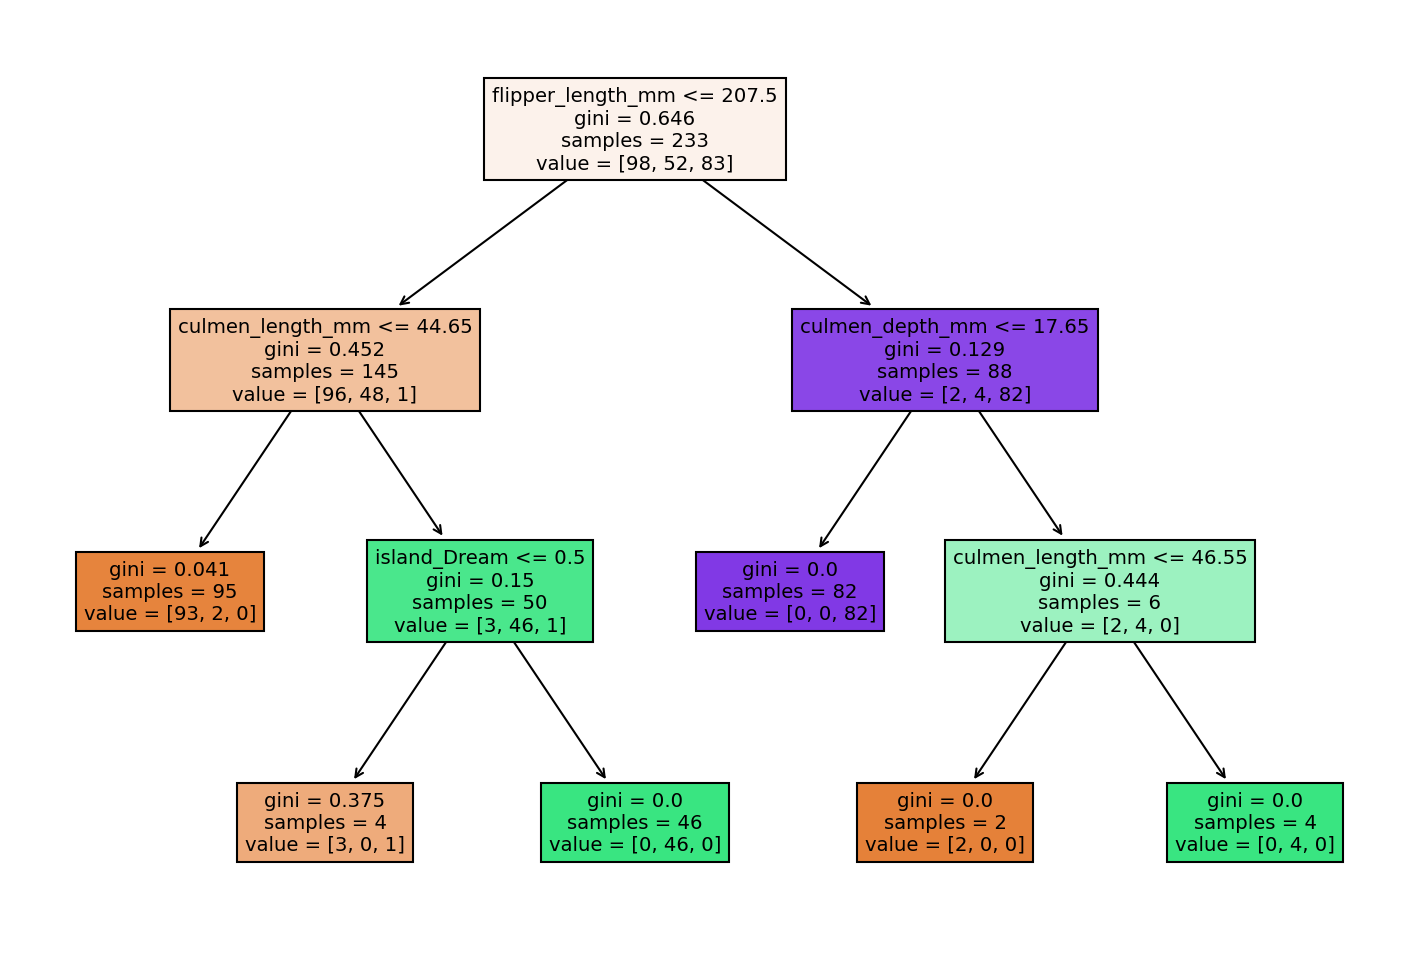

In [43]:
pruned_tree=DecisionTreeClassifier(max_leaf_nodes=6)
report_model(pruned_tree)